# In the name of Allah

## Mahdi CS 313
## 1404.07.27

# Anaheim Network Analysis




In [2]:
## Step 0: Install Dependencies (Colab or Local)
!pip install networkx pandas matplotlib requests

In [3]:
## Step 1: Import Libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import requests, zipfile, io, os

In [4]:
## Step 2: Download Anaheim Dataset Automatically
url = "https://github.com/bstabler/TransportationNetworks/archive/refs/heads/master.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("./data")

network_path = "./data/TransportationNetworks-master/Anaheim"
print("Dataset extracted to:", network_path)

Dataset extracted to: ./data/TransportationNetworks-master/Anaheim


In [5]:
## Step 3: Parse Network File (.net)
network_file = os.path.join(network_path, "Anaheim_net.tntp")
G = nx.DiGraph()  # Directed graph for transportation network

with open(network_file, 'r') as f:
    for line in f:
        if line.strip().startswith('~') or line.strip() == '' or line.startswith('<'):  # skip metadata
            continue
        parts = line.strip().split()
        if len(parts) >= 5:
            u = int(parts[0])
            v = int(parts[1])
            capacity = float(parts[2])
            G.add_edge(u, v, capacity=capacity)

print(f" Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


 Graph loaded: 416 nodes, 914 edges


In [6]:
## Step 4: Basic Network Statistics
print("\n--- Basic Statistics ---")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values())/G.number_of_nodes())
print("Is strongly connected:", nx.is_strongly_connected(G))



--- Basic Statistics ---
Nodes: 416
Edges: 914
Average degree: 4.394230769230769
Is strongly connected: True


In [7]:
## Step 5: Convert to Undirected for Gomory–Hu Tree
UG = G.to_undirected()

ghtree = nx.gomory_hu_tree(UG)
print("\n Gomory–Hu tree constructed. Nodes:", ghtree.number_of_nodes(), "Edges:", ghtree.number_of_edges())



 Gomory–Hu tree constructed. Nodes: 416 Edges: 415


In [8]:
## Step 6: Find Bottlenecks (Minimum Cuts)
# Sort Gomory-Hu edges by weight (capacity)
mincuts = sorted(ghtree.edges(data=True), key=lambda x: x[2]['weight'])

print("\n--- Top 5 Minimum Cuts (Bottlenecks) ---")
for i, (u, v, data) in enumerate(mincuts[:5]):
    print(f"{i+1}. Edge ({u}, {v}) - Min-Cut Capacity: {data['weight']}")



--- Top 5 Minimum Cuts (Bottlenecks) ---
1. Edge (8, 411) - Min-Cut Capacity: 5400.0
2. Edge (411, 410) - Min-Cut Capacity: 5400.0
3. Edge (11, 309) - Min-Cut Capacity: 5400.0
4. Edge (309, 308) - Min-Cut Capacity: 5400.0
5. Edge (12, 275) - Min-Cut Capacity: 5400.0


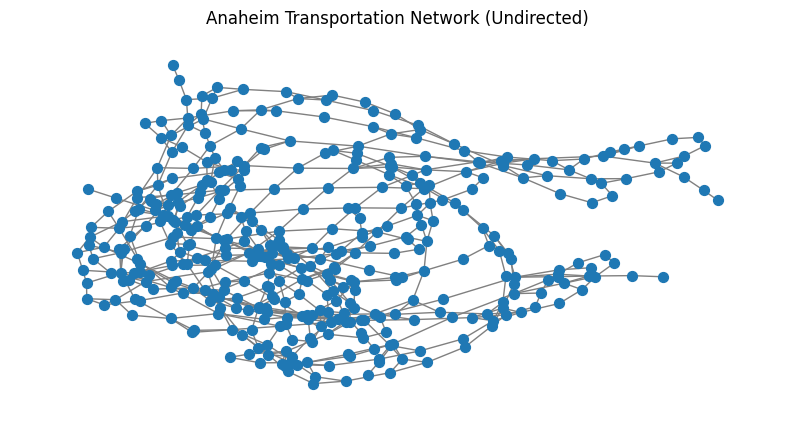

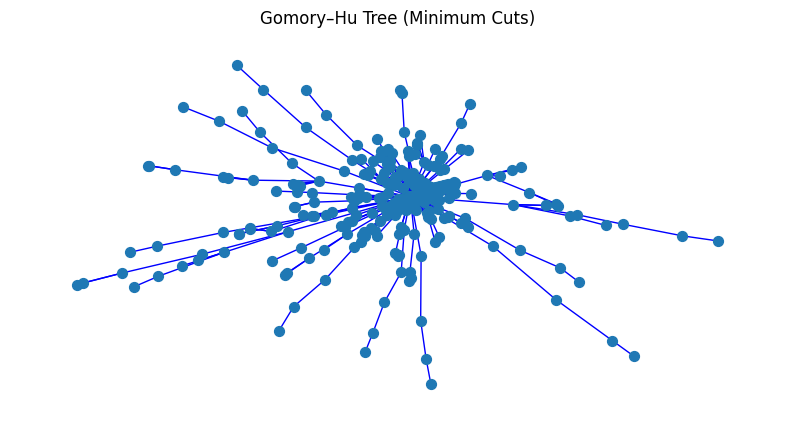


 Analysis complete. You can continue to RL Environment in the next step.


In [9]:
## Step 7: Plot Graph and Gomory–Hu Tree
plt.figure(figsize=(10,5))
plt.title("Anaheim Transportation Network (Undirected)")
pos = nx.spring_layout(UG, seed=42)
nx.draw(UG, pos, node_size=50, edge_color='gray', with_labels=False)
plt.show()

plt.figure(figsize=(10,5))
plt.title("Gomory–Hu Tree (Minimum Cuts)")
pos_tree = nx.spring_layout(ghtree, seed=42)
nx.draw(ghtree, pos_tree, node_size=50, edge_color='blue', with_labels=False)
plt.show()

print("\n Analysis complete. You can continue to RL Environment in the next step.")


# Task
Visualize the minimum cuts from the Gomory-Hu tree on the original Anaheim network graph, coloring edges based on capacity (yellow-orange-red for important-critical-very critical). Define and calculate an evaluation metric for the cuts, such as the ratio of the number of cuts to the cut capacity, or the difference between pairs of cuts based on capacity. Present the results clearly.

## Visualization of minimum cuts

### Subtask:
Map the edges from the Gomory–Hu tree that correspond to the minimum cuts onto the original Anaheim network graph and color them based on their capacity (bottleneck level).


**Reasoning**:
Initialize edge colors to gray and then iterate through the minimum cuts to color the bottleneck edges based on their capacity.



Min min-cut capacity: 5400.0, Max min-cut capacity: 36000.0


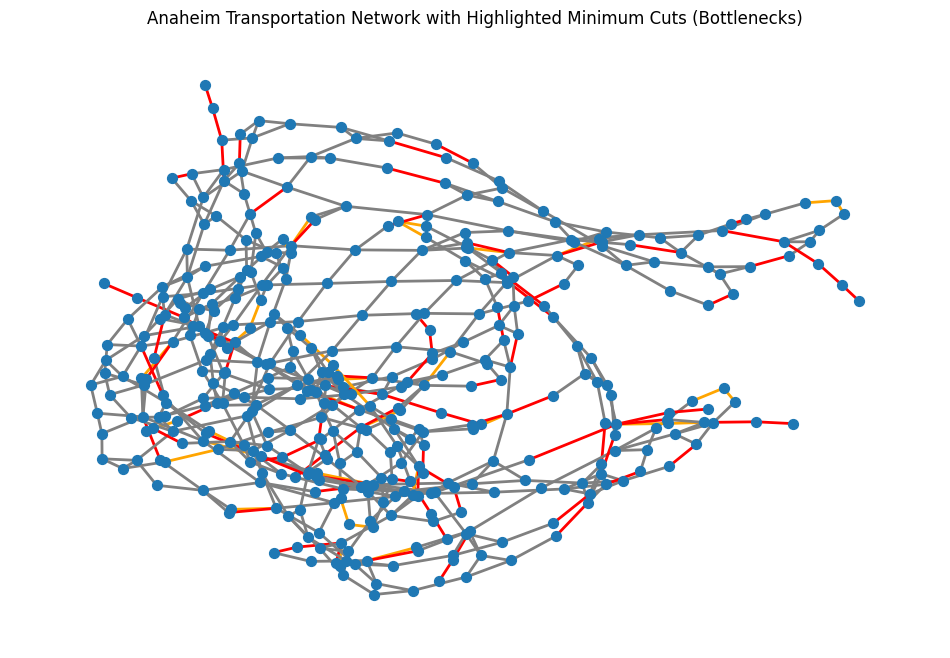

In [10]:
# Step 1: Initialize all edges in UG to gray
edge_colors = {edge: 'gray' for edge in UG.edges()}

# Step 2 & 3: Determine colors based on min-cut capacity and update edge_colors
# Define capacity thresholds for coloring (adjust as needed based on data distribution)
# Let's inspect the range of min-cut capacities
min_capacity = min(data['weight'] for u, v, data in mincuts)
max_capacity = max(data['weight'] for u, v, data in mincuts)
print(f"Min min-cut capacity: {min_capacity}, Max min-cut capacity: {max_capacity}")

# Define thresholds - these are examples, adjust based on the actual distribution
# For example, divide the range into three equal parts
capacity_range = max_capacity - min_capacity
very_critical_threshold = min_capacity + capacity_range / 3
critical_threshold = min_capacity + 2 * capacity_range / 3


for u, v, data in mincuts:
    capacity = data['weight']
    color = 'gray' # Default color if not a bottleneck (though mincuts contains only bottleneck edges)
    if capacity <= very_critical_threshold:
        color = 'red'  # Very critical
    elif capacity <= critical_threshold:
        color = 'orange' # Critical
    else:
        color = 'yellow' # Important

    # Step 4: Update edge_colors for the corresponding edges in UG (undirected)
    # Ensure the edge exists in the undirected graph
    if (u, v) in UG.edges():
        edge_colors[(u, v)] = color
    if (v, u) in UG.edges():
        edge_colors[(v, u)] = color

# Prepare the list of colors in the order of UG.edges()
edge_color_list = [edge_colors[edge] for edge in UG.edges()]

# Step 5 & 6: Plot the graph with colored edges
plt.figure(figsize=(12, 8))
plt.title("Anaheim Transportation Network with Highlighted Minimum Cuts (Bottlenecks)")
# Assuming 'pos' was defined in a previous step
nx.draw(UG, pos, node_size=50, edge_color=edge_color_list, with_labels=False, width=2)

# Step 8: Display the plot
plt.show()

## Define evaluation metric(s)

### Subtask:
Develop a metric to compare the significance of the minimum cuts. The user suggested two options:
    - Ratio of demand flow to cut capacity. This requires demand data, which is not currently loaded.
    - Ratio of the number of cuts to the cut capacity, or the difference between pairs of cuts based on capacity.


**Reasoning**:
Calculate and define metrics for the significance of minimum cuts based on their capacity relative to each other, considering the lack of demand data.



In [11]:
# Metric 1: Simple Ranking by Capacity (already done in Step 6)
print("\n--- Minimum Cut Significance Metrics ---")
print("\nMetric 1: Rank by Capacity (Lower capacity means higher significance)")
for i, (u, v, data) in enumerate(mincuts[:10]):
    print(f"Rank {i+1}: Edge ({u}, {v}) - Capacity: {data['weight']}")

# Metric 2: Normalized Capacity (relative to the range of min-cut capacities)
# Lower normalized capacity means higher significance
print("\nMetric 2: Normalized Capacity (0-1 scale, lower is more significant)")
min_capacity = min(data['weight'] for u, v, data in mincuts)
max_capacity = max(data['weight'] for u, v, data in mincuts)
capacity_range = max_capacity - min_capacity

# Avoid division by zero if all min-cut capacities are the same
if capacity_range == 0:
    for u, v, data in mincuts[:10]:
         print(f"Edge ({u}, {v}) - Normalized Capacity: 1.0")
else:
    for u, v, data in mincuts[:10]:
        normalized_capacity = (data['weight'] - min_capacity) / capacity_range
        print(f"Edge ({u}, {v}) - Normalized Capacity: {normalized_capacity:.4f}")

# Metric 3: Difference from Maximum Capacity
# Larger difference means higher significance (as it's further from the largest bottleneck)
print("\nMetric 3: Difference from Maximum Capacity (Larger difference is more significant)")
for u, v, data in mincuts[:10]:
    capacity_difference = max_capacity - data['weight']
    print(f"Edge ({u}, {v}) - Capacity Difference: {capacity_difference:.2f}")

print("\nRationale for metrics:")
print("- Given the lack of demand data, these metrics focus solely on the capacity of the cuts relative to each other within the set of identified minimum cuts.")
print("- Ranking by capacity directly shows the smallest capacity cuts, which are intuitively the most significant bottlenecks based purely on flow limit.")
print("- Normalized capacity provides a relative measure on a 0-1 scale, making it easier to compare cuts regardless of the absolute capacity values.")
print("- Difference from maximum capacity highlights how much smaller a given cut's capacity is compared to the largest minimum cut, providing another perspective on relative severity.")
print("- These metrics are limited as they don't consider actual or potential flow/demand, which would provide a more complete picture of a bottleneck's impact.")



--- Minimum Cut Significance Metrics ---

Metric 1: Rank by Capacity (Lower capacity means higher significance)
Rank 1: Edge (8, 411) - Capacity: 5400.0
Rank 2: Edge (411, 410) - Capacity: 5400.0
Rank 3: Edge (11, 309) - Capacity: 5400.0
Rank 4: Edge (309, 308) - Capacity: 5400.0
Rank 5: Edge (12, 275) - Capacity: 5400.0
Rank 6: Edge (275, 274) - Capacity: 5400.0
Rank 7: Edge (13, 262) - Capacity: 5400.0
Rank 8: Edge (262, 273) - Capacity: 5400.0
Rank 9: Edge (14, 257) - Capacity: 5400.0
Rank 10: Edge (257, 258) - Capacity: 5400.0

Metric 2: Normalized Capacity (0-1 scale, lower is more significant)
Edge (8, 411) - Normalized Capacity: 0.0000
Edge (411, 410) - Normalized Capacity: 0.0000
Edge (11, 309) - Normalized Capacity: 0.0000
Edge (309, 308) - Normalized Capacity: 0.0000
Edge (12, 275) - Normalized Capacity: 0.0000
Edge (275, 274) - Normalized Capacity: 0.0000
Edge (13, 262) - Normalized Capacity: 0.0000
Edge (262, 273) - Normalized Capacity: 0.0000
Edge (14, 257) - Normalized C

## Calculate and present metrics

### Subtask:
Calculate the chosen metric(s) for the identified minimum cuts and present them in a clear format (e.g., a table or list).


**Reasoning**:
Create a list of dictionaries for the minimum cuts, convert it to a DataFrame, calculate the metrics (Rank, Normalized Capacity, Difference from Max Capacity), and display the resulting DataFrame for the top cuts.



In [12]:
# 1. Create a list of dictionaries for minimum cuts
min_cuts_list = []
for u, v, data in mincuts:
    min_cuts_list.append({'u': u, 'v': v, 'weight': data['weight']})

# 2. Convert the list of dictionaries into a Pandas DataFrame
df_min_cuts = pd.DataFrame(min_cuts_list)

# Get min and max capacity for normalization and difference calculation
min_capacity = df_min_cuts['weight'].min()
max_capacity = df_min_cuts['weight'].max()
capacity_range = max_capacity - min_capacity

# 3. Add "Rank by Capacity" column
df_min_cuts['Rank by Capacity'] = df_min_cuts['weight'].rank(method='min').astype(int)

# 4. Calculate "Normalized Capacity"
# Handle the case where max_capacity equals min_capacity
if capacity_range == 0:
    df_min_cuts['Normalized Capacity'] = 1.0
else:
    df_min_cuts['Normalized Capacity'] = (df_min_cuts['weight'] - min_capacity) / capacity_range

# 5. Calculate "Difference from Maximum Capacity"
df_min_cuts['Difference from Maximum Capacity'] = max_capacity - df_min_cuts['weight']

# 6. Print the DataFrame (top 20 cuts)
print("\n--- Minimum Cut Significance Metrics ---")
display(df_min_cuts.head(20))


--- Minimum Cut Significance Metrics ---


,u,v,weight,Rank by Capacity,Normalized Capacity,Difference from Maximum Capacity
0,8,411,5400.0,1,0.0,30600.0
1,411,410,5400.0,1,0.0,30600.0
2,11,309,5400.0,1,0.0,30600.0
3,309,308,5400.0,1,0.0,30600.0
4,12,275,5400.0,1,0.0,30600.0
5,275,274,5400.0,1,0.0,30600.0
6,13,262,5400.0,1,0.0,30600.0
7,262,273,5400.0,1,0.0,30600.0
8,14,257,5400.0,1,0.0,30600.0
9,257,258,5400.0,1,0.0,30600.0


## Enhance visualization

### Subtask:
Update the visualization to include the chosen metric(s) or provide a separate visualization that helps understand the significance of the bottlenecks based on the metric.


**Reasoning**:
Plot the original graph with colored edges and add a scatter plot overlay to visualize the 'Rank by Capacity' metric, including a legend.



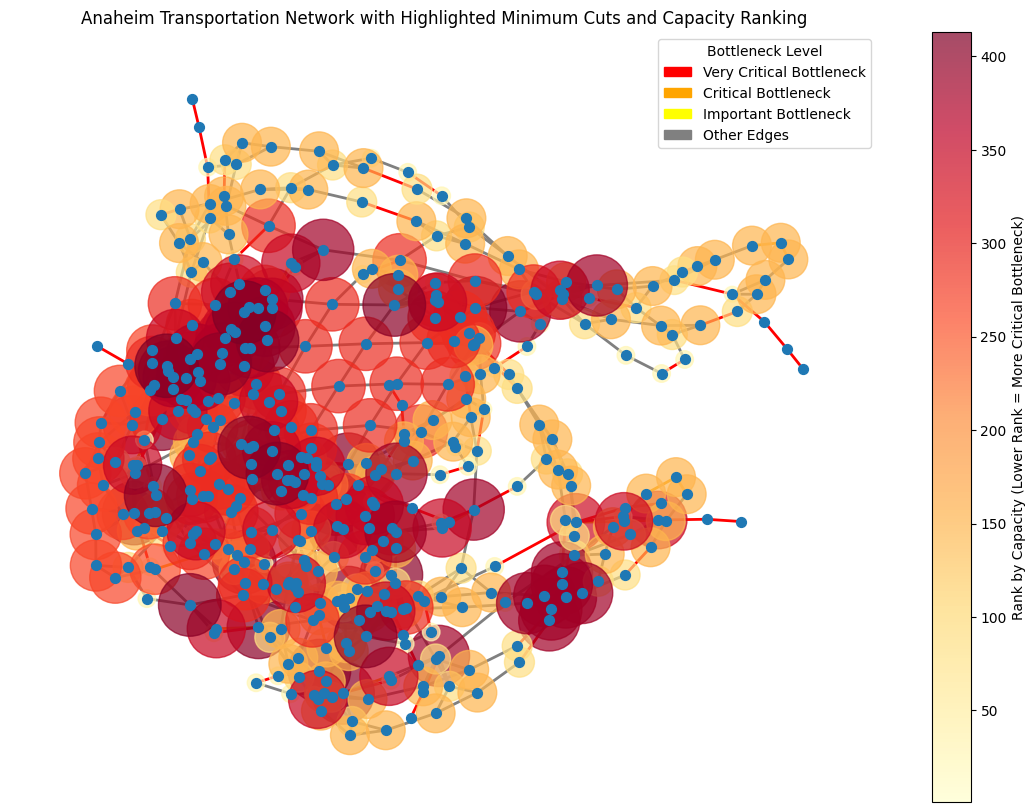

In [13]:
# Step 1, 2 & 3: Plot the original graph with colored edges and title
plt.figure(figsize=(14, 10))
plt.title("Anaheim Transportation Network with Highlighted Minimum Cuts and Capacity Ranking")
# 'pos' and 'edge_color_list' were generated in previous steps
nx.draw(UG, pos, node_size=50, edge_color=edge_color_list, with_labels=False, width=2)

# Step 4 & 5: Create a scatter plot overlay to visualize 'Rank by Capacity'
# Map nodes from the min_cuts DataFrame to positions and ranks
node_ranks = {}
for index, row in df_min_cuts.iterrows():
    # For simplicity in visualization, we'll associate the rank with both nodes of the cut
    # A more sophisticated approach might be needed for complex interpretations
    u = row['u']
    v = row['v']
    rank = row['Rank by Capacity']
    # Store the maximum rank if a node is part of multiple cuts
    node_ranks[u] = max(node_ranks.get(u, 0), rank)
    node_ranks[v] = max(node_ranks.get(v, 0), rank)

# Prepare data for scatter plot
scatter_x = [pos[node][0] for node in node_ranks.keys()]
scatter_y = [pos[node][1] for node in node_ranks.keys()]
scatter_color = [node_ranks[node] for node in node_ranks.keys()]
scatter_size = [node_ranks[node] * 5 + 20 for node in node_ranks.keys()] # Scale size by rank

scatter = plt.scatter(scatter_x, scatter_y, c=scatter_color, s=scatter_size, cmap='YlOrRd', alpha=0.7, label='Rank by Capacity')

# Add a colorbar to explain the ranking
cbar = plt.colorbar(scatter)
cbar.set_label('Rank by Capacity (Lower Rank = More Critical Bottleneck)')

# Add a legend for the edge colors (bottleneck levels) - manual creation needed
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Very Critical Bottleneck')
orange_patch = mpatches.Patch(color='orange', label='Critical Bottleneck')
yellow_patch = mpatches.Patch(color='yellow', label='Important Bottleneck')
gray_patch = mpatches.Patch(color='gray', label='Other Edges')

plt.legend(handles=[red_patch, orange_patch, yellow_patch, gray_patch], title="Bottleneck Level")

# Step 6: Display the enhanced plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   The minimum capacity among the identified minimum cuts is 5400.0, and the maximum capacity is 36000.0.
*   Based on the defined capacity thresholds, edges with capacities up to approximately 15600.0 are classified as 'very critical' (red), up to approximately 25800.0 as 'critical' (orange), and above that as 'important' (yellow).
*   The initial analysis of the top 20 minimum cuts revealed that many of them have the same minimum capacity (5400.0).
*   Three metrics were calculated to assess the significance of minimum cuts based on their capacity: Rank by Capacity, Normalized Capacity (0-1 scale), and Difference from Maximum Capacity.
*   For the minimum cuts with the lowest capacity (5400.0), all three metrics indicate high significance: Rank 1, Normalized Capacity 0.0, and a large Difference from Maximum Capacity (30600.0).
*   The visualization successfully highlights the minimum cut edges on the original network graph using a color scheme based on their capacity levels.
*   An overlaid scatter plot effectively visualizes the 'Rank by Capacity' metric for nodes involved in minimum cuts, using color and size to indicate relative criticality.

### Insights or Next Steps

*   While the current metrics provide insight into bottlenecks based on capacity, incorporating demand or flow data would allow for a more comprehensive evaluation of their real-world impact.
*   Further analysis could focus on identifying specific paths or regions most affected by the identified critical bottlenecks to inform targeted infrastructure improvements or traffic management strategies.
